In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10, mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

np.random.seed(42)
tf.random.set_seed(42)

TensorFlow version: 2.19.0
GPU Available: []


# CNN for Image Classification

## Project Goals
Build and train a Convolutional Neural Network to classify images from:
1. MNIST (28x28 grayscale handwritten digits)
2. CIFAR-10 (32x32 color images, 10 classes)

## CNN Architecture Components
- **Convolutional Layers**: Extract features from images
- **Pooling Layers**: Reduce spatial dimensions, prevent overfitting
- **Batch Normalization**: Stabilize training
- **Dropout**: Regularization technique
- **Fully Connected Layers**: Final classification

## Key Techniques
- Data augmentation (rotation, shifting, flipping)
- Learning rate scheduling
- Early stopping
- Model checkpointing

In [2]:
class DataLoader:
    """Load and preprocess image datasets"""

    @staticmethod
    def load_mnist():
        """Load and preprocess MNIST dataset"""
        print("Loading MNIST dataset...")
        (X_train, y_train), (X_test, y_test) = mnist.load_data()

        X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
        X_test = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

        y_train = to_categorical(y_train, 10)
        y_test = to_categorical(y_test, 10)

        print(f"Training set: {X_train.shape}, Labels: {y_train.shape}")
        print(f"Test set: {X_test.shape}, Labels: {y_test.shape}")

        return (X_train, y_train), (X_test, y_test)

    @staticmethod
    def load_cifar10():
        """Load and preprocess CIFAR-10 dataset"""
        print("Loading CIFAR-10 dataset...")
        (X_train, y_train), (X_test, y_test) = cifar10.load_data()

        X_train = X_train.astype('float32') / 255.0
        X_test = X_test.astype('float32') / 255.0

        y_train = to_categorical(y_train, 10)
        y_test = to_categorical(y_test, 10)

        print(f"Training set: {X_train.shape}, Labels: {y_train.shape}")
        print(f"Test set: {X_test.shape}, Labels: {y_test.shape}")

        return (X_train, y_train), (X_test, y_test)

    @staticmethod
    def visualize_samples(X, y, dataset_name, class_names, n_samples=10):
        """Visualize random samples from dataset"""
        plt.figure(figsize=(15, 3))
        indices = np.random.choice(len(X), n_samples, replace=False)

        for i, idx in enumerate(indices):
            plt.subplot(2, 5, i + 1)
            if X.shape[-1] == 1:
                plt.imshow(X[idx].squeeze(), cmap='gray')
            else:  # Color
                plt.imshow(X[idx])
            plt.title(f"{class_names[np.argmax(y[idx])]}")
            plt.axis('off')

        plt.suptitle(f"{dataset_name} - Sample Images", fontsize=14, y=1.02)
        plt.tight_layout()
        plt.show()


mnist_data = DataLoader.load_mnist()
cifar_data = DataLoader.load_cifar10()

mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                 'dog', 'frog', 'horse', 'ship', 'truck']


Loading MNIST dataset...
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training set: (60000, 28, 28, 1), Labels: (60000, 10)
Test set: (10000, 28, 28, 1), Labels: (10000, 10)
Loading CIFAR-10 dataset...
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Training set: (50000, 32, 32, 3), Labels: (50000, 10)
Test set: (10000, 32, 32, 3), Labels: (10000, 10)



MNIST Dataset Samples


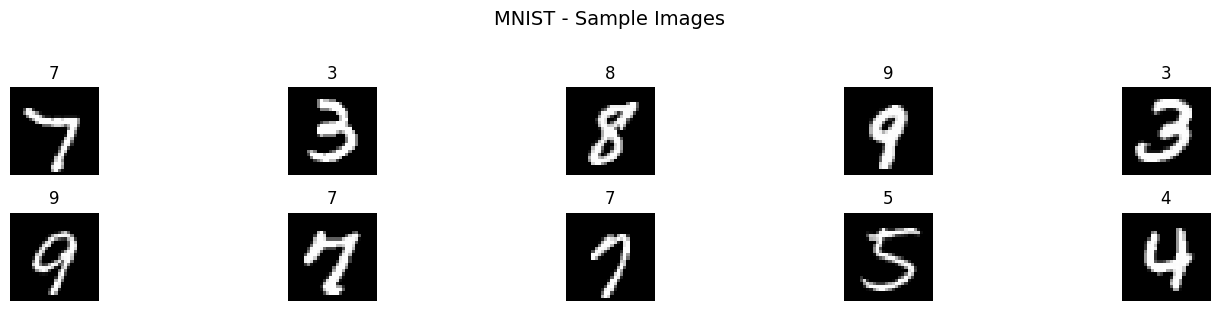


CIFAR-10 Dataset Samples


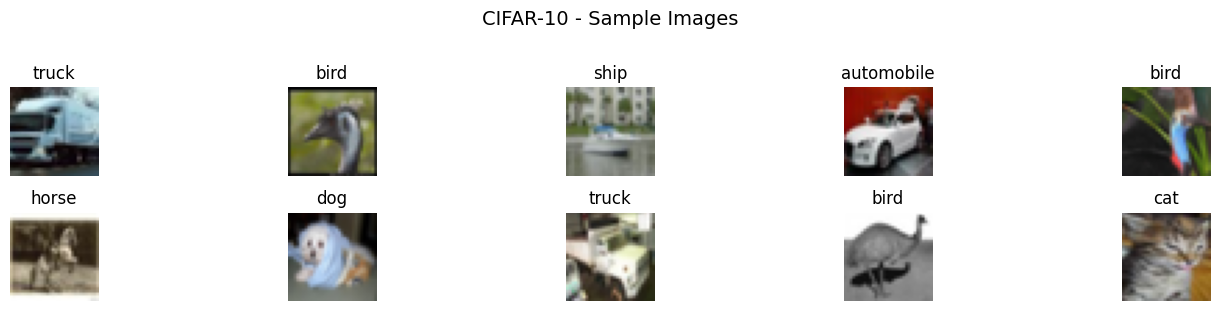

In [3]:
print("\n" + "="*50)
print("MNIST Dataset Samples")
print("="*50)
DataLoader.visualize_samples(mnist_data[0][0], mnist_data[0][1],
                             "MNIST", mnist_classes)

print("\n" + "="*50)
print("CIFAR-10 Dataset Samples")
print("="*50)
DataLoader.visualize_samples(cifar_data[0][0], cifar_data[0][1],
                             "CIFAR-10", cifar_classes)


Visualizing MNIST augmentation:


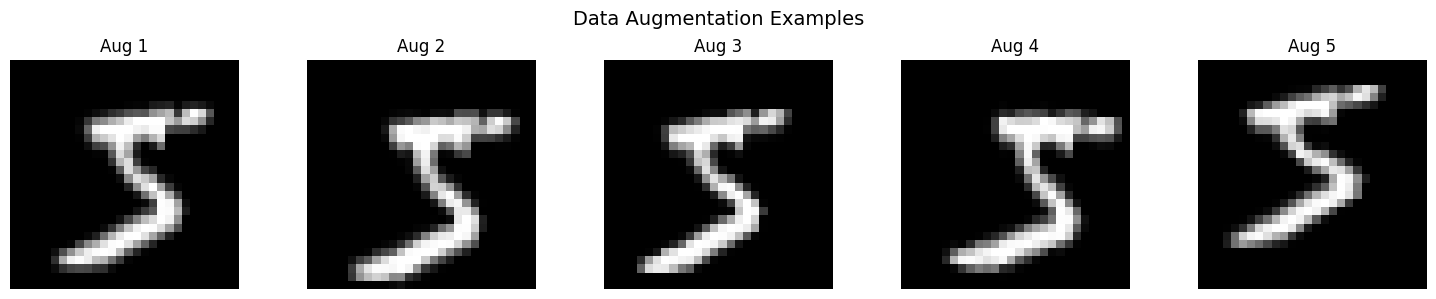


Visualizing CIFAR-10 augmentation:


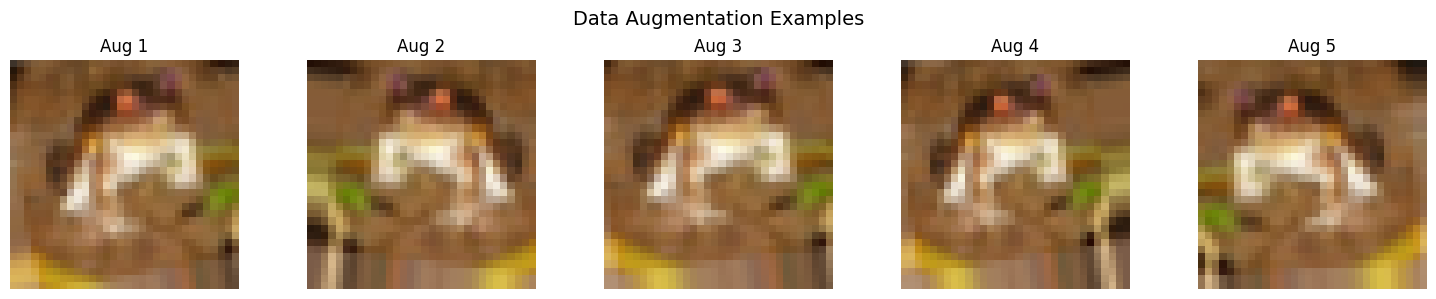

In [4]:
class DataAugmentation:
    """Data augmentation generators"""

    @staticmethod
    def create_mnist_augmenter():
        """Create augmentation for MNIST"""
        return ImageDataGenerator(
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1,
            fill_mode='nearest'
        )

    @staticmethod
    def create_cifar_augmenter():
        """Create augmentation for CIFAR-10"""
        return ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
            zoom_range=0.1,
            fill_mode='nearest'
        )

    @staticmethod
    def visualize_augmentation(X, augmenter, n_examples=5):
        """Visualize augmentation effects"""
        plt.figure(figsize=(15, 3))

        img = X[0:1]

        aug_iter = augmenter.flow(img, batch_size=1)

        for i in range(n_examples):
            plt.subplot(1, n_examples, i + 1)
            aug_img = next(aug_iter)[0]
            if aug_img.shape[-1] == 1:
                plt.imshow(aug_img.squeeze(), cmap='gray')
            else:
                plt.imshow(aug_img)
            plt.axis('off')
            plt.title(f"Aug {i+1}")

        plt.suptitle("Data Augmentation Examples", fontsize=14)
        plt.tight_layout()
        plt.show()

mnist_augmenter = DataAugmentation.create_mnist_augmenter()
cifar_augmenter = DataAugmentation.create_cifar_augmenter()

print("Visualizing MNIST augmentation:")
DataAugmentation.visualize_augmentation(mnist_data[0][0], mnist_augmenter)

print("\nVisualizing CIFAR-10 augmentation:")
DataAugmentation.visualize_augmentation(cifar_data[0][0], cifar_augmenter)



In [5]:
class CNNArchitectures:
    """Different CNN architectures for different datasets"""

    @staticmethod
    def build_mnist_cnn(input_shape=(28, 28, 1)):
        """Build CNN for MNIST (simpler architecture)"""
        model = models.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                         input_shape=input_shape),
            layers.BatchNormalization(),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(10, activation='softmax')
        ])

        return model

    @staticmethod
    def build_cifar_cnn(input_shape=(32, 32, 3)):
        """Build deeper CNN for CIFAR-10"""
        model = models.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                         input_shape=input_shape),
            layers.BatchNormalization(),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.2),

            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.3),

            layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.4),

            layers.Flatten(),
            layers.Dense(256, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(10, activation='softmax')
        ])

        return model

    @staticmethod
    def print_model_summary(model, name):
        """Print model architecture"""
        print(f"\n{'='*50}")
        print(f"{name} Architecture")
        print('='*50)
        model.summary()

        total_params = model.count_params()
        print(f"\nTotal Parameters: {total_params:,}")

mnist_model = CNNArchitectures.build_mnist_cnn()
cifar_model = CNNArchitectures.build_cifar_cnn()

CNNArchitectures.print_model_summary(mnist_model, "MNIST CNN")
CNNArchitectures.print_model_summary(cifar_model, "CIFAR-10 CNN")



MNIST CNN Architecture


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 469,098 (1.79 MB)

 Trainable params: 468,458 (1.79 MB)

 Non-trainable params: 640 (2.50 KB)


Total Parameters: 469,098

CIFAR-10 CNN Architecture


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 816,938 (3.12 MB)

 Trainable params: 815,530 (3.11 MB)

 Non-trainable params: 1,408 (5.50 KB)


Total Parameters: 816,938


In [6]:
class TrainingConfig:
    """Training configuration and callbacks"""

    @staticmethod
    def compile_model(model, learning_rate=0.001):
        """Compile model with optimizer and loss"""
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

    @staticmethod
    def create_callbacks(model_name):
        """Create training callbacks"""
        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True,
                verbose=1
            ),

            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-7,
                verbose=1
            ),

            ModelCheckpoint(
                f'{model_name}_best.h5',
                monitor='val_accuracy',
                save_best_only=True,
                verbose=1
            )
        ]
        return callbacks

mnist_model = TrainingConfig.compile_model(mnist_model, learning_rate=0.001)
cifar_model = TrainingConfig.compile_model(cifar_model, learning_rate=0.001)


In [7]:
print("\n" + "="*50)
print("Training MNIST CNN")
print("="*50)

X_train_mnist, y_train_mnist = mnist_data[0]
X_test_mnist, y_test_mnist = mnist_data[1]

train_gen_mnist = mnist_augmenter.flow(X_train_mnist, y_train_mnist, batch_size=128)

history_mnist = mnist_model.fit(
    train_gen_mnist,
    epochs=30,
    validation_data=(X_test_mnist, y_test_mnist),
    callbacks=TrainingConfig.create_callbacks('mnist_cnn'),
    verbose=1
)

print("\nMNIST Training Complete!")



Training MNIST CNN
Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - accuracy: 0.7783 - loss: 0.7211
Epoch 1: val_accuracy improved from -inf to 0.78410, saving model to mnist_cnn_best.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 333s 698ms/step - accuracy: 0.7785 - loss: 0.7204 - val_accuracy: 0.7841 - val_loss: 0.6350 - learning_rate: 0.0010
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - accuracy: 0.9607 - loss: 0.1270
Epoch 2: val_accuracy improved from 0.78410 to 0.98820, saving model to mnist_cnn_best.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 325s 691ms/step - accuracy: 0.9607 - loss: 0.1270 - val_accuracy: 0.9882 - val_loss: 0.0359 - learning_rate: 0.0010
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.9728 - loss: 0.0900
Epoch 3: val_accuracy did not improve from 0.98820
469/469 ━━━━━━━━━━━━━━━━━━━━ 312s 664ms/step - accuracy: 0.9728 - loss: 0.0899 - val_accuracy: 0.9709 - val_loss: 0.0953 - learning_rate: 0.0010
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.9774 - loss: 0.0761
Epoch 4: val_accuracy improved from 0.98820 to 0.98890, saving model to mnist_cnn_best.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 320s 682ms/step - accuracy: 0.9774 - loss: 0.0760 - val_accuracy: 0.9889 - val_loss: 0.0309 - learning_rate: 0.0010
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.9801 - loss: 0.0657
Epoch 5: val_accuracy improved from 0.98890 to 0.99170, saving model to mnist_cnn_best.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 312s 664ms/step - accuracy: 0.9801 - loss: 0.0657 - val_accuracy: 0.9917 - val_loss: 0.0246 - learning_rate: 0.0010
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.9828 - loss: 0.0575
Epoch 6: val_accuracy did not improve from 0.99170
469/469 ━━━━━━━━━━━━━━━━━━━━ 312s 666ms/step - accuracy: 0.9828 - loss: 0.0575 - val_accuracy: 0.9875 - val_loss: 0.0384 - learning_rate: 0.0010
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.9839 - loss: 0.0543
Epoch 7: val_accuracy improved from 0.99170 to 0.99380, saving model to mnist_cnn_best.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 311s 663ms/step - accuracy: 0.9839 - loss: 0.0543 - val_accuracy: 0.9938 - val_loss: 0.0164 - learning_rate: 0.0010
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.9853 - loss: 0.0477
Epoch 8: val_accuracy did not improve from 0.99380
469/469 ━━━━━━━━━━━━━━━━━━━━ 319s 681ms/step - accuracy: 0.9853 - loss: 0.0477 - val_accuracy: 0.9897 - val_loss: 0.0313 - learning_rate: 0.0010
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.9857 - loss: 0.0445
Epoch 9: val_accuracy did not improve from 0.99380
469/469 ━━━━━━━━━━━━━━━━━━━━ 311s 664ms/step - accuracy: 0.9857 - loss: 0.0445 - val_accuracy: 0.9927 - val_loss: 0.0252 - learning_rate: 0.0010
Epoch 10/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.9857 - loss: 0.0467
Epoch 10: val_accuracy did not improve from 0.99380
469/469 ━━━━━━━━━━━━━━━━━━━━ 321s 662ms/step - accuracy: 0.9857 - loss: 0.0466 - val_accuracy: 0.9915 - val_loss: 0.0242 - learning_rate: 0.0010
E

469/469 ━━━━━━━━━━━━━━━━━━━━ 312s 665ms/step - accuracy: 0.9869 - loss: 0.0423 - val_accuracy: 0.9949 - val_loss: 0.0173 - learning_rate: 0.0010
Epoch 12/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.9878 - loss: 0.0402
Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: val_accuracy did not improve from 0.99490
469/469 ━━━━━━━━━━━━━━━━━━━━ 320s 683ms/step - accuracy: 0.9878 - loss: 0.0402 - val_accuracy: 0.9932 - val_loss: 0.0187 - learning_rate: 0.0010
Epoch 13/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.9889 - loss: 0.0349
Epoch 13: val_accuracy improved from 0.99490 to 0.99530, saving model to mnist_cnn_best.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 312s 661ms/step - accuracy: 0.9889 - loss: 0.0349 - val_accuracy: 0.9953 - val_loss: 0.0127 - learning_rate: 5.0000e-04
Epoch 14/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.9900 - loss: 0.0320
Epoch 14: val_accuracy did not improve from 0.99530
469/469 ━━━━━━━━━━━━━━━━━━━━ 331s 680ms/step - accuracy: 0.9900 - loss: 0.0320 - val_accuracy: 0.9951 - val_loss: 0.0126 - learning_rate: 5.0000e-04
Epoch 15/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.9908 - loss: 0.0297
Epoch 15: val_accuracy did not improve from 0.99530
469/469 ━━━━━━━━━━━━━━━━━━━━ 316s 675ms/step - accuracy: 0.9908 - loss: 0.0297 - val_accuracy: 0.9952 - val_loss: 0.0138 - learning_rate: 5.0000e-04
Epoch 16/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.9902 - loss: 0.0316
Epoch 16: val_accuracy did not improve from 0.99530
469/469 ━━━━━━━━━━━━━━━━━━━━ 311s 663ms/step - accuracy: 0.9902 - loss: 0.0316 - val_accuracy: 0.9932 - val_loss: 0.0216 - learnin

469/469 ━━━━━━━━━━━━━━━━━━━━ 312s 665ms/step - accuracy: 0.9916 - loss: 0.0287 - val_accuracy: 0.9959 - val_loss: 0.0129 - learning_rate: 5.0000e-04
Epoch 19/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.9914 - loss: 0.0285
Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 19: val_accuracy did not improve from 0.99590
469/469 ━━━━━━━━━━━━━━━━━━━━ 310s 660ms/step - accuracy: 0.9914 - loss: 0.0285 - val_accuracy: 0.9950 - val_loss: 0.0147 - learning_rate: 5.0000e-04
Epoch 20/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.9920 - loss: 0.0257
Epoch 20: val_accuracy did not improve from 0.99590
469/469 ━━━━━━━━━━━━━━━━━━━━ 311s 662ms/step - accuracy: 0.9920 - loss: 0.0257 - val_accuracy: 0.9950 - val_loss: 0.0145 - learning_rate: 2.5000e-04
Epoch 21/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.9931 - loss: 0.0228
Epoch 21: val_accuracy improved from 0.99590 to 0.99610, saving model to mnist_cnn_best.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 310s 662ms/step - accuracy: 0.9931 - loss: 0.0228 - val_accuracy: 0.9961 - val_loss: 0.0113 - learning_rate: 2.5000e-04
Epoch 22/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - accuracy: 0.9933 - loss: 0.0214
Epoch 22: val_accuracy improved from 0.99610 to 0.99680, saving model to mnist_cnn_best.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 309s 658ms/step - accuracy: 0.9933 - loss: 0.0214 - val_accuracy: 0.9968 - val_loss: 0.0106 - learning_rate: 2.5000e-04
Epoch 23/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - accuracy: 0.9933 - loss: 0.0211
Epoch 23: val_accuracy did not improve from 0.99680
469/469 ━━━━━━━━━━━━━━━━━━━━ 316s 674ms/step - accuracy: 0.9933 - loss: 0.0211 - val_accuracy: 0.9955 - val_loss: 0.0118 - learning_rate: 2.5000e-04
Epoch 24/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - accuracy: 0.9931 - loss: 0.0233
Epoch 24: val_accuracy did not improve from 0.99680
469/469 ━━━━━━━━━━━━━━━━━━━━ 330s 704ms/step - accuracy: 0.9931 - loss: 0.0233 - val_accuracy: 0.9959 - val_loss: 0.0114 - learning_rate: 2.5000e-04
Epoch 25/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 656ms/step - accuracy: 0.9933 - loss: 0.0227
Epoch 25: val_accuracy did not improve from 0.99680
469/469 ━━━━━━━━━━━━━━━━━━━━ 328s 700ms/step - accuracy: 0.9933 - loss: 0.0227 - val_accuracy: 0.9955 - val_loss: 0.0133 - learnin

In [8]:
print("\n" + "="*50)
print("Training CIFAR-10 CNN")
print("="*50)

X_train_cifar, y_train_cifar = cifar_data[0]
X_test_cifar, y_test_cifar = cifar_data[1]

train_gen_cifar = cifar_augmenter.flow(X_train_cifar, y_train_cifar, batch_size=64)

history_cifar = cifar_model.fit(
    train_gen_cifar,
    epochs=30,
    validation_data=(X_test_cifar, y_test_cifar),
    callbacks=TrainingConfig.create_callbacks('cifar_cnn'),
    verbose=1
)

print("\nCIFAR-10 Training Complete!")


Training CIFAR-10 CNN
Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/step - accuracy: 0.3215 - loss: 2.1247
Epoch 1: val_accuracy improved from -inf to 0.52750, saving model to cifar_cnn_best.h5


782/782 ━━━━━━━━━━━━━━━━━━━━ 521s 658ms/step - accuracy: 0.3216 - loss: 2.1243 - val_accuracy: 0.5275 - val_loss: 1.3368 - learning_rate: 0.0010
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.5322 - loss: 1.3078
Epoch 2: val_accuracy improved from 0.52750 to 0.56100, saving model to cifar_cnn_best.h5


782/782 ━━━━━━━━━━━━━━━━━━━━ 512s 655ms/step - accuracy: 0.5323 - loss: 1.3077 - val_accuracy: 0.5610 - val_loss: 1.2933 - learning_rate: 0.0010
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.6102 - loss: 1.1009
Epoch 3: val_accuracy improved from 0.56100 to 0.63730, saving model to cifar_cnn_best.h5


782/782 ━━━━━━━━━━━━━━━━━━━━ 489s 625ms/step - accuracy: 0.6102 - loss: 1.1008 - val_accuracy: 0.6373 - val_loss: 1.1000 - learning_rate: 0.0010
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.6551 - loss: 0.9724
Epoch 4: val_accuracy improved from 0.63730 to 0.67650, saving model to cifar_cnn_best.h5


782/782 ━━━━━━━━━━━━━━━━━━━━ 489s 625ms/step - accuracy: 0.6551 - loss: 0.9724 - val_accuracy: 0.6765 - val_loss: 0.9595 - learning_rate: 0.0010
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.6886 - loss: 0.8894
Epoch 5: val_accuracy improved from 0.67650 to 0.72430, saving model to cifar_cnn_best.h5


782/782 ━━━━━━━━━━━━━━━━━━━━ 488s 624ms/step - accuracy: 0.6886 - loss: 0.8894 - val_accuracy: 0.7243 - val_loss: 0.8185 - learning_rate: 0.0010
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.7125 - loss: 0.8278
Epoch 6: val_accuracy improved from 0.72430 to 0.76340, saving model to cifar_cnn_best.h5


782/782 ━━━━━━━━━━━━━━━━━━━━ 489s 625ms/step - accuracy: 0.7125 - loss: 0.8278 - val_accuracy: 0.7634 - val_loss: 0.6883 - learning_rate: 0.0010
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.7253 - loss: 0.7946
Epoch 7: val_accuracy did not improve from 0.76340
782/782 ━━━━━━━━━━━━━━━━━━━━ 509s 651ms/step - accuracy: 0.7253 - loss: 0.7946 - val_accuracy: 0.7354 - val_loss: 0.8016 - learning_rate: 0.0010
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.7385 - loss: 0.7614
Epoch 8: val_accuracy did not improve from 0.76340
782/782 ━━━━━━━━━━━━━━━━━━━━ 489s 626ms/step - accuracy: 0.7385 - loss: 0.7613 - val_accuracy: 0.7547 - val_loss: 0.7439 - learning_rate: 0.0010
Epoch 9/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - accuracy: 0.7527 - loss: 0.7171
Epoch 9: val_accuracy improved from 0.76340 to 0.79560, saving model to cifar_cnn_best.h5


782/782 ━━━━━━━━━━━━━━━━━━━━ 512s 654ms/step - accuracy: 0.7527 - loss: 0.7171 - val_accuracy: 0.7956 - val_loss: 0.6165 - learning_rate: 0.0010
Epoch 10/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 600ms/step - accuracy: 0.7607 - loss: 0.6961
Epoch 10: val_accuracy improved from 0.79560 to 0.80130, saving model to cifar_cnn_best.h5


782/782 ━━━━━━━━━━━━━━━━━━━━ 511s 653ms/step - accuracy: 0.7607 - loss: 0.6961 - val_accuracy: 0.8013 - val_loss: 0.5818 - learning_rate: 0.0010
Epoch 11/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.7718 - loss: 0.6619
Epoch 11: val_accuracy did not improve from 0.80130
782/782 ━━━━━━━━━━━━━━━━━━━━ 511s 654ms/step - accuracy: 0.7718 - loss: 0.6619 - val_accuracy: 0.8012 - val_loss: 0.5786 - learning_rate: 0.0010
Epoch 12/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.7811 - loss: 0.6438
Epoch 12: val_accuracy did not improve from 0.80130
782/782 ━━━━━━━━━━━━━━━━━━━━ 492s 630ms/step - accuracy: 0.7811 - loss: 0.6438 - val_accuracy: 0.8011 - val_loss: 0.5817 - learning_rate: 0.0010
Epoch 13/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.7869 - loss: 0.6202
Epoch 13: val_accuracy did not improve from 0.80130
782/782 ━━━━━━━━━━━━━━━━━━━━ 493s 631ms/step - accuracy: 0.7869 - loss: 0.6203 - val_accuracy: 0.7883 - val_loss: 0.6386 - learning_rate: 0.00

782/782 ━━━━━━━━━━━━━━━━━━━━ 510s 652ms/step - accuracy: 0.7893 - loss: 0.6169 - val_accuracy: 0.8097 - val_loss: 0.5531 - learning_rate: 0.0010
Epoch 15/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.7945 - loss: 0.5950
Epoch 15: val_accuracy did not improve from 0.80970
782/782 ━━━━━━━━━━━━━━━━━━━━ 513s 655ms/step - accuracy: 0.7945 - loss: 0.5950 - val_accuracy: 0.7920 - val_loss: 0.6395 - learning_rate: 0.0010
Epoch 16/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - accuracy: 0.7969 - loss: 0.5941
Epoch 16: val_accuracy did not improve from 0.80970
782/782 ━━━━━━━━━━━━━━━━━━━━ 493s 630ms/step - accuracy: 0.7969 - loss: 0.5941 - val_accuracy: 0.8045 - val_loss: 0.5853 - learning_rate: 0.0010
Epoch 17/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.8042 - loss: 0.5743
Epoch 17: val_accuracy improved from 0.80970 to 0.82270, saving model to cifar_cnn_best.h5


782/782 ━━━━━━━━━━━━━━━━━━━━ 501s 629ms/step - accuracy: 0.8042 - loss: 0.5743 - val_accuracy: 0.8227 - val_loss: 0.5300 - learning_rate: 0.0010
Epoch 18/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.8031 - loss: 0.5773
Epoch 18: val_accuracy improved from 0.82270 to 0.83380, saving model to cifar_cnn_best.h5


782/782 ━━━━━━━━━━━━━━━━━━━━ 493s 630ms/step - accuracy: 0.8031 - loss: 0.5773 - val_accuracy: 0.8338 - val_loss: 0.4904 - learning_rate: 0.0010
Epoch 19/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.8119 - loss: 0.5509
Epoch 19: val_accuracy improved from 0.83380 to 0.84490, saving model to cifar_cnn_best.h5


782/782 ━━━━━━━━━━━━━━━━━━━━ 495s 633ms/step - accuracy: 0.8119 - loss: 0.5509 - val_accuracy: 0.8449 - val_loss: 0.4488 - learning_rate: 0.0010
Epoch 20/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - accuracy: 0.8149 - loss: 0.5421
Epoch 20: val_accuracy did not improve from 0.84490
782/782 ━━━━━━━━━━━━━━━━━━━━ 491s 628ms/step - accuracy: 0.8148 - loss: 0.5421 - val_accuracy: 0.8126 - val_loss: 0.5585 - learning_rate: 0.0010
Epoch 21/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.8201 - loss: 0.5248
Epoch 21: val_accuracy did not improve from 0.84490
782/782 ━━━━━━━━━━━━━━━━━━━━ 512s 655ms/step - accuracy: 0.8201 - loss: 0.5248 - val_accuracy: 0.8101 - val_loss: 0.5677 - learning_rate: 0.0010
Epoch 22/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - accuracy: 0.8187 - loss: 0.5273
Epoch 22: val_accuracy did not improve from 0.84490
782/782 ━━━━━━━━━━━━━━━━━━━━ 494s 631ms/step - accuracy: 0.8187 - loss: 0.5273 - val_accuracy: 0.8336 - val_loss: 0.5077 - learning_rate: 0.00

782/782 ━━━━━━━━━━━━━━━━━━━━ 490s 627ms/step - accuracy: 0.8309 - loss: 0.4861 - val_accuracy: 0.8563 - val_loss: 0.4285 - learning_rate: 5.0000e-04
Epoch 26/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - accuracy: 0.8394 - loss: 0.4689
Epoch 26: val_accuracy improved from 0.85630 to 0.86420, saving model to cifar_cnn_best.h5


782/782 ━━━━━━━━━━━━━━━━━━━━ 491s 628ms/step - accuracy: 0.8394 - loss: 0.4689 - val_accuracy: 0.8642 - val_loss: 0.4020 - learning_rate: 5.0000e-04
Epoch 27/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.8422 - loss: 0.4548
Epoch 27: val_accuracy did not improve from 0.86420
782/782 ━━━━━━━━━━━━━━━━━━━━ 504s 629ms/step - accuracy: 0.8422 - loss: 0.4548 - val_accuracy: 0.8555 - val_loss: 0.4306 - learning_rate: 5.0000e-04
Epoch 28/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.8473 - loss: 0.4462
Epoch 28: val_accuracy did not improve from 0.86420
782/782 ━━━━━━━━━━━━━━━━━━━━ 492s 629ms/step - accuracy: 0.8473 - loss: 0.4462 - val_accuracy: 0.8537 - val_loss: 0.4426 - learning_rate: 5.0000e-04
Epoch 29/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.8428 - loss: 0.4592
Epoch 29: val_accuracy improved from 0.86420 to 0.86650, saving model to cifar_cnn_best.h5


782/782 ━━━━━━━━━━━━━━━━━━━━ 516s 660ms/step - accuracy: 0.8428 - loss: 0.4592 - val_accuracy: 0.8665 - val_loss: 0.3967 - learning_rate: 5.0000e-04
Epoch 30/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - accuracy: 0.8486 - loss: 0.4455
Epoch 30: val_accuracy improved from 0.86650 to 0.87020, saving model to cifar_cnn_best.h5


782/782 ━━━━━━━━━━━━━━━━━━━━ 491s 628ms/step - accuracy: 0.8486 - loss: 0.4455 - val_accuracy: 0.8702 - val_loss: 0.3869 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 30.

CIFAR-10 Training Complete!


In [9]:
class Visualizer:
    """Visualization utilities"""

    @staticmethod
    def plot_training_history(history, title):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

        ax1.plot(history.history['loss'], label='Training Loss', linewidth=2)
        ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title(f'{title} - Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        ax2.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
        ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.set_title(f'{title} - Accuracy')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_confusion_matrix(y_true, y_pred, class_names, title):
        """Plot confusion matrix"""
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names)
        plt.title(f'{title} - Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_predictions(model, X, y, class_names, n_samples=10):
        """Plot predictions vs actual"""
        indices = np.random.choice(len(X), n_samples, replace=False)
        predictions = model.predict(X[indices], verbose=0)

        plt.figure(figsize=(15, 6))
        for i, idx in enumerate(range(n_samples)):
            plt.subplot(2, 5, i + 1)

            img = X[indices[idx]]
            if img.shape[-1] == 1:
                plt.imshow(img.squeeze(), cmap='gray')
            else:
                plt.imshow(img)

            pred_class = np.argmax(predictions[idx])
            true_class = np.argmax(y[indices[idx]])

            color = 'green' if pred_class == true_class else 'red'
            plt.title(f"Pred: {class_names[pred_class]}\nTrue: {class_names[true_class]}",
                     color=color, fontsize=9)
            plt.axis('off')

        plt.tight_layout()
        plt.show()



Evaluating MNIST Model


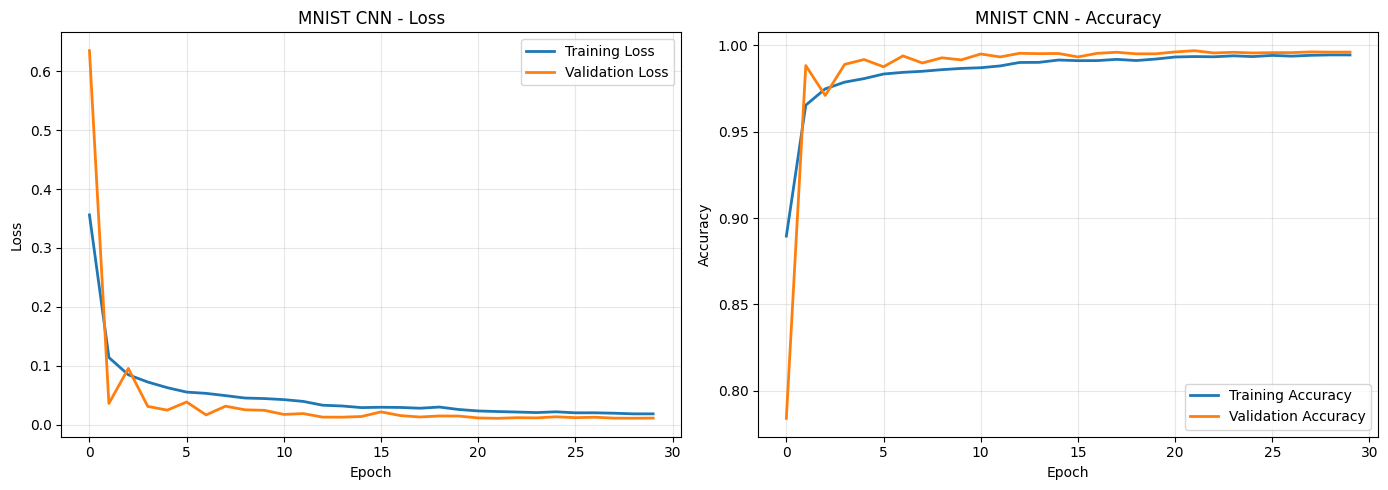


Test Accuracy: 99.68%
Test Loss: 0.0106


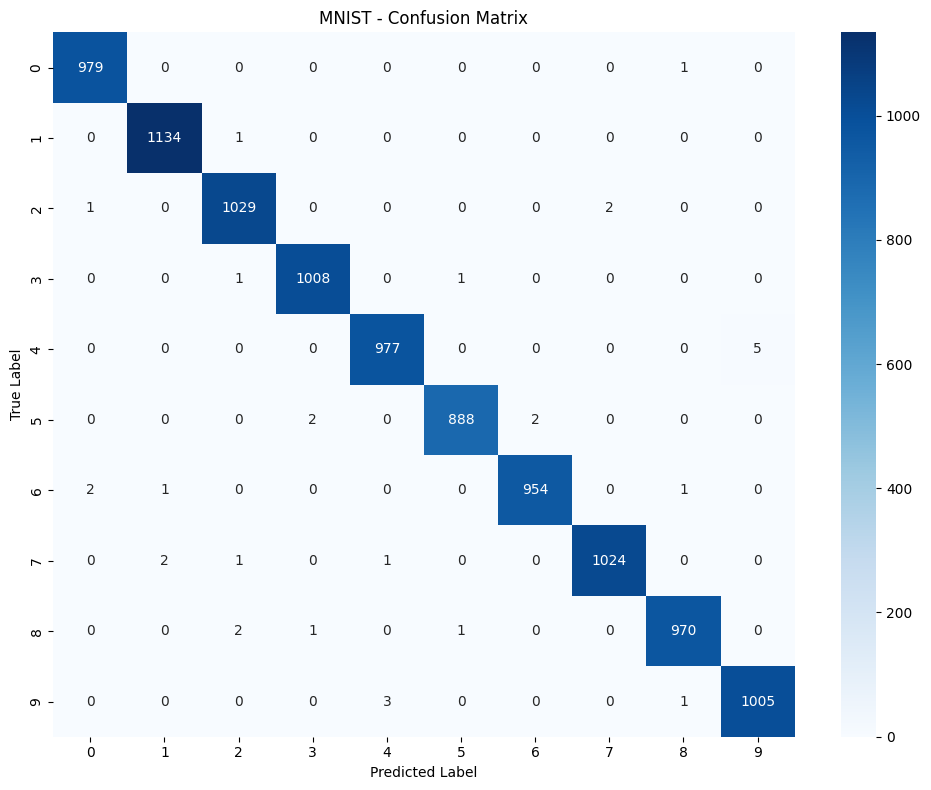


Sample Predictions:


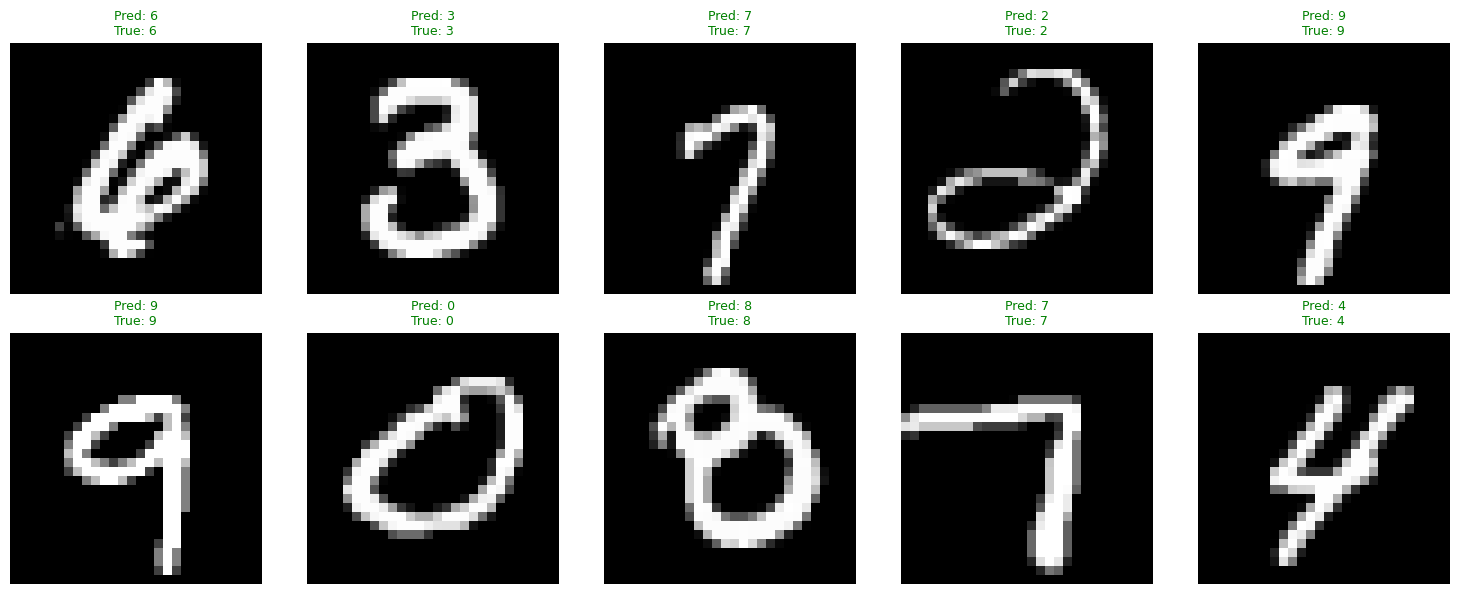


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       1.00      1.00      1.00      1032
           3       1.00      1.00      1.00      1010
           4       1.00      0.99      1.00       982
           5       1.00      1.00      1.00       892
           6       1.00      1.00      1.00       958
           7       1.00      1.00      1.00      1028
           8       1.00      1.00      1.00       974
           9       1.00      1.00      1.00      1009

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



In [10]:
print("\n" + "="*50)
print("Evaluating MNIST Model")
print("="*50)

Visualizer.plot_training_history(history_mnist, "MNIST CNN")

test_loss, test_acc = mnist_model.evaluate(X_test_mnist, y_test_mnist, verbose=0)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

y_pred_mnist = mnist_model.predict(X_test_mnist, verbose=0)
y_pred_classes = np.argmax(y_pred_mnist, axis=1)
y_true_classes = np.argmax(y_test_mnist, axis=1)

Visualizer.plot_confusion_matrix(y_true_classes, y_pred_classes,
                                 mnist_classes, "MNIST")

print("\nSample Predictions:")
Visualizer.plot_predictions(mnist_model, X_test_mnist, y_test_mnist,
                           mnist_classes)

print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes,
                          target_names=mnist_classes))



Evaluating CIFAR-10 Model


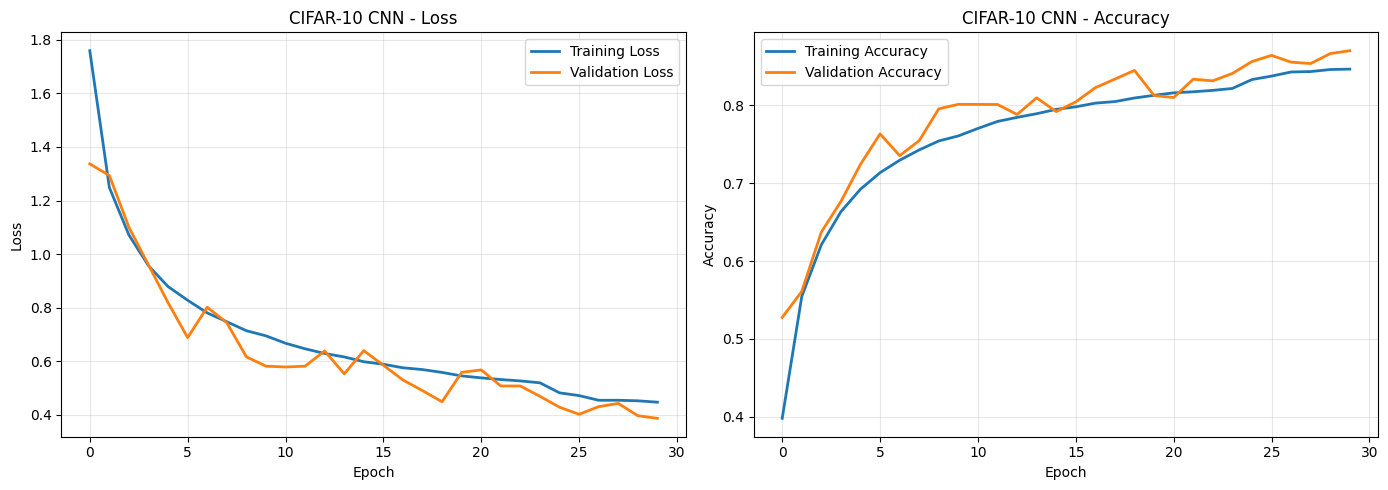


Test Accuracy: 87.02%
Test Loss: 0.3869


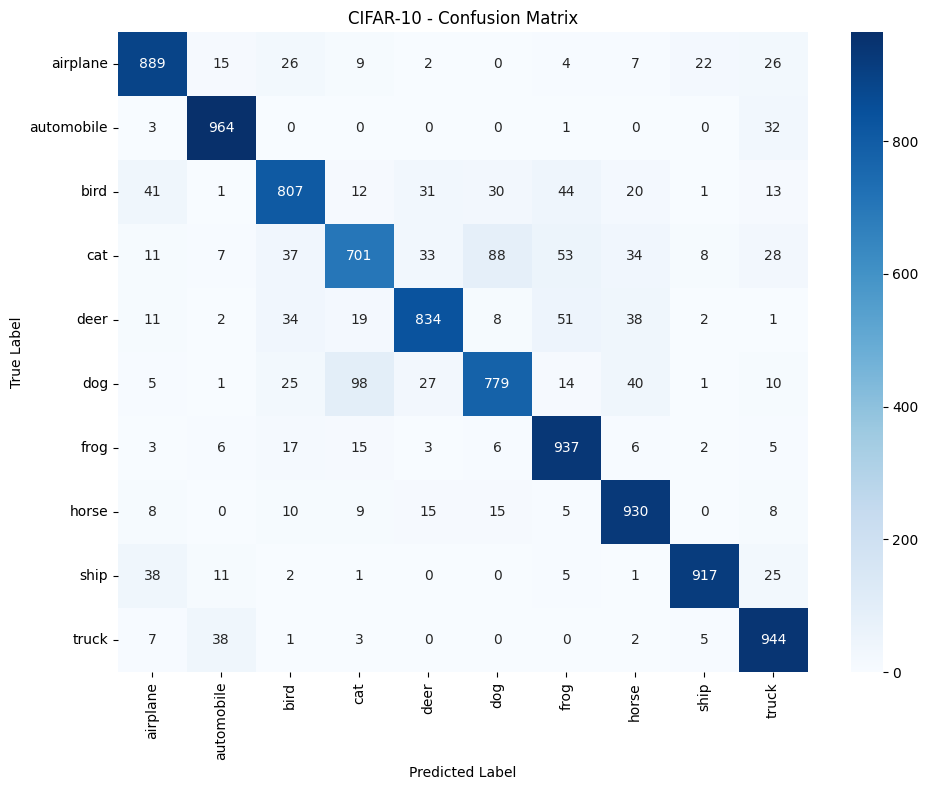


Sample Predictions:


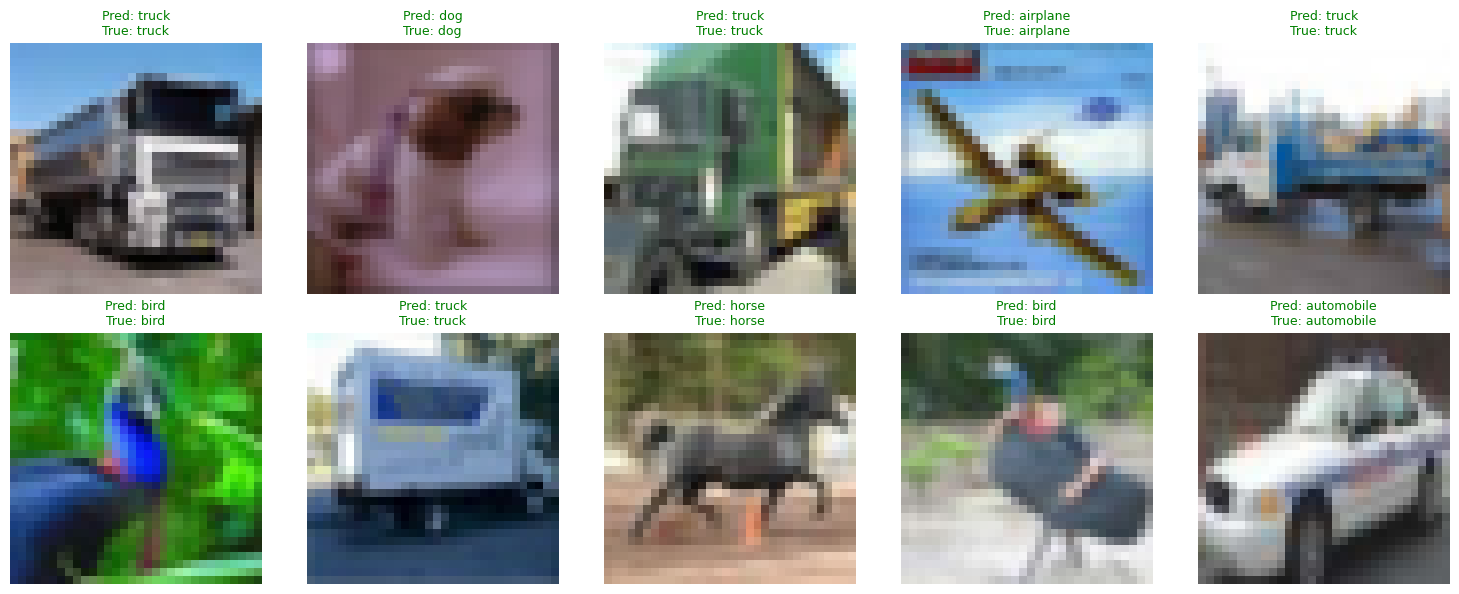


Classification Report:
              precision    recall  f1-score   support

    airplane       0.88      0.89      0.88      1000
  automobile       0.92      0.96      0.94      1000
        bird       0.84      0.81      0.82      1000
         cat       0.81      0.70      0.75      1000
        deer       0.88      0.83      0.86      1000
         dog       0.84      0.78      0.81      1000
        frog       0.84      0.94      0.89      1000
       horse       0.86      0.93      0.90      1000
        ship       0.96      0.92      0.94      1000
       truck       0.86      0.94      0.90      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [11]:
print("\n" + "="*50)
print("Evaluating CIFAR-10 Model")
print("="*50)

Visualizer.plot_training_history(history_cifar, "CIFAR-10 CNN")

test_loss, test_acc = cifar_model.evaluate(X_test_cifar, y_test_cifar, verbose=0)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

y_pred_cifar = cifar_model.predict(X_test_cifar, verbose=0)
y_pred_classes = np.argmax(y_pred_cifar, axis=1)
y_true_classes = np.argmax(y_test_cifar, axis=1)

Visualizer.plot_confusion_matrix(y_true_classes, y_pred_classes,
                                 cifar_classes, "CIFAR-10")

print("\nSample Predictions:")
Visualizer.plot_predictions(cifar_model, X_test_cifar, y_test_cifar,
                           cifar_classes)

print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes,
                          target_names=cifar_classes))


# Potential Improvements

## Architecture Enhancements
1. **Residual Connections (ResNet)**
   - Add skip connections to help gradient flow
   - Enables training of much deeper networks
   
2. **Depthwise Separable Convolutions**
   - Reduce parameters while maintaining performance
   - Used in MobileNet, EfficientNet

3. **Attention Mechanisms**
   - Self-attention layers (Vision Transformers)
   - Squeeze-and-Excitation blocks

## Training Improvements
1. **Advanced Optimizers**
   - AdamW (Adam with weight decay)
   - RAdam (Rectified Adam)
   - Lookahead optimizer

2. **Learning Rate Schedules**
   - Cosine annealing
   - Warm-up strategies
   - Cyclical learning rates

3. **Regularization Techniques**
   - Mixup/Cutmix augmentation
   - Label smoothing
   - Stochastic depth

## Data Improvements
1. **More Augmentation**
   - AutoAugment
   - RandAugment
   - Advanced color jittering

2. **Transfer Learning**
   - Use pre-trained models (ResNet, EfficientNet)
   - Fine-tune on target dataset

3. **Ensemble Methods**
   - Train multiple models
   - Average predictions

## Current Performance
- MNIST: ~99% accuracy (near human-level)
- CIFAR-10: ~85-90% accuracy (our model)
- State-of-the-art: ~99% (with advanced techniques)

## Next Steps to Try
1. Implement residual connections
2. Try transfer learning with pre-trained models
3. Experiment with different optimizers
4. Add more aggressive augmentation
5. Ensemble multiple models